In [1]:
import numpy as np 

from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.kernel_approximation import Nystroem, RBFSampler

import seaborn as sns 
import matplotlib.pyplot as pl 

%matplotlib inline 

sns.set_style('darkgrid')
sns.set_context('paper')

In [18]:
def prob_conf_plot(X, y, clf, buf=0.1, cmap=None, 
                   viz_type=None, n_samples=301, alpha=1.0):
    """
    
    Args:
        X: 2d ndarray, NxD. 
            The input features. This function expects that D=2 
            (i.e. that the problem is two dimensional).
        y: 1d ndarray, length of N.
            The labels associated with the data, X. 
        clf: sklearn model.
            This model must implement the `predict_proba` method. 
        buf: real, greater than 0. Default 0.1
            This argument determines how much whitespace to place
            around the limit of the data. 
        cmap: colour map. Default: None.
            This argument defines the base colour map for the 
            visualised datapoints and for the data that fills it.
            The default system-wide colour map is used when 
            this argument is `None`. 
        viz_type: must be one of {'hard', 'soft'}. Default: 'soft'. 
            Determines the type of visualisation that is to be 
            executed. 'hard' produces a visualisation on the 
            decision function whereas 'soft' also depicts
            predictive confidence. 
        n_samples: int, greater than 0. Default: 301
            Predictions are visualised on a 2D grid over the range
            of the features. This argument determines how many 
            samples are used in generating the grid. 
        alpha: float, greater than or equal to 0, less than or equal 
            to 1. Default: 1
            The transparancy of the visualisation. 
    Returns:

    """
    
    assert X.shape[1] == 2
    if viz_type is None: 
        viz_type = 'soft'
    else:
        viz_type = viz_type.lower()
    assert viz_type in {'hard', 'soft'}
    
    # Determine the extent of the data 
    extent = (
        X[:, 0].min() - buf, X[:, 0].max() + buf,
        X[:, 1].min() - buf, X[:, 1].max() + buf,
    )
    
    # Generate sample points in the range of the data, and evaluate model over it 
    xx, yy = np.meshgrid(
        np.linspace(extent[0], extent[1], n_samples),
        np.linspace(extent[2], extent[3], n_samples),
    )
    
    # Get predictions
    pp = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    if viz_type == 'hard':
        p = np.zeros_like(pp)
        p[np.arange(p.shape[0]), pp.argmax(axis=1)] = 1
        pp = p
    n_classes = pp.shape[1]
    
    # Get cmap 
    if cmap is None:
        cmap = sns.color_palette()
    
    fig, ax = pl.subplots(1, 1, figsize=(10, 10))
    cols = sns.color_palette(cmap, n_classes)
    pp_rgba = np.zeros((n_samples, n_samples, 4))
    for ci, pi in zip(cols, pp.T):
        cmap_i = pl.cm.colors.ListedColormap(ci)
        pi = np.clip(pi, 0, 1).reshape(xx.shape)
        pp_rgba += cmap_i(pi) * pi[..., None]
    pl.imshow(pp_rgba, alpha=alpha, extent=extent, origin='lower', aspect=1)
    
    # Plot the decision boundaries 
    pl.contour(
        xx, yy, pp.argmax(axis=1).reshape(xx.shape),
        alpha=alpha, colors='k', zorder=1
    )
    
    # Plot the raw data 
    cmap = pl.cm.colors.ListedColormap(cols.as_hex())
    pl.scatter(
        X[:, 0], X[:, 1],
        c=y, s=100,
        cmap=cmap,
        ec='k',
        alpha=0.9
    )
    
    pl.tight_layout()


In [19]:
# Make classification dataset
iris = load_iris()
X = MinMaxScaler(feature_range=(-1, 1)).fit_transform(
    iris.data[:, [1, 3]]
)
y = iris.target

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


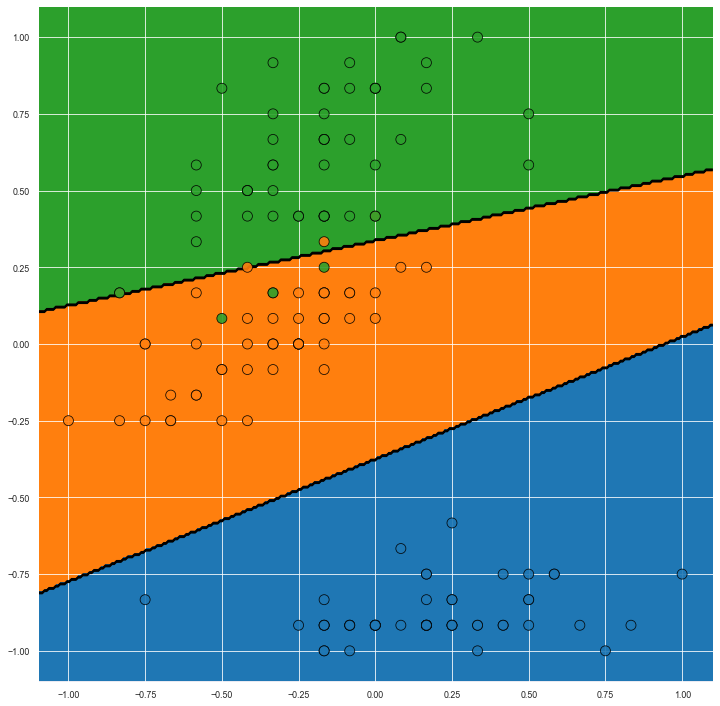

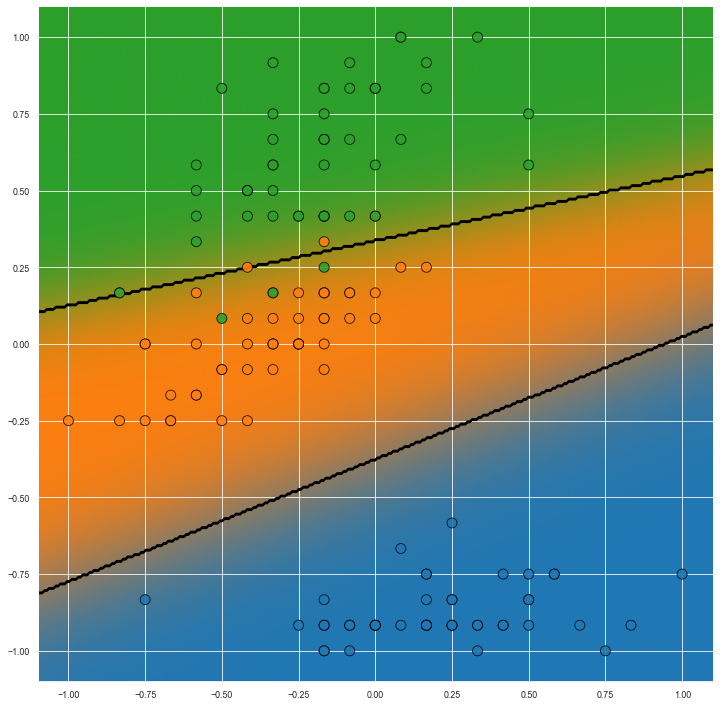

In [20]:
# Learn the classification model
clf = SVC(kernel='linear', C=1, probability=True)
clf = LogisticRegressionCV(cv=5, multi_class='multinomial')
clf.fit(X, y)

# Print the decision boundary
for viz_type in ('hard', 'soft'):
    prob_conf_plot(X, y, clf, viz_type=viz_type)
    pl.savefig(f'{viz_type}.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


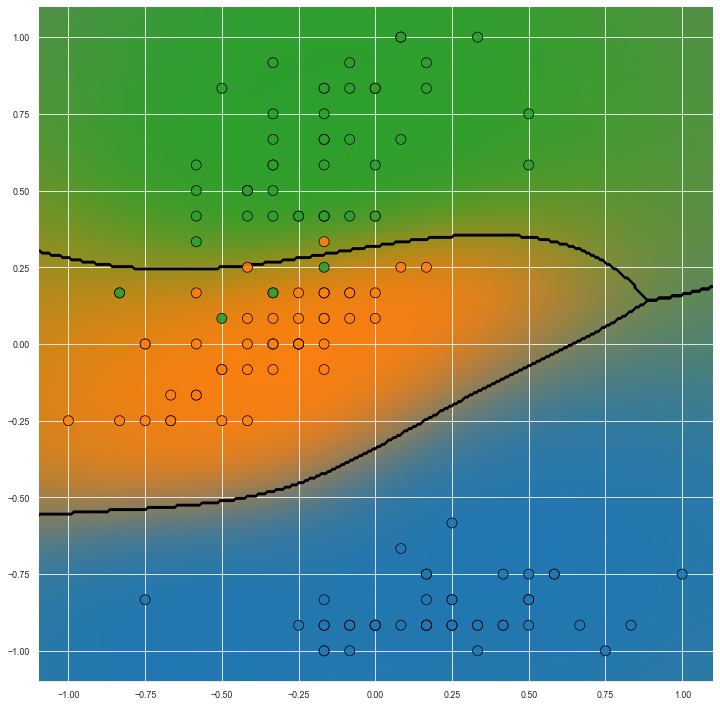

In [21]:
# Learn the classification model
clf = SVC(kernel='rbf', gamma=2, C=2, probability=True)
clf.fit(X, y)

# Print the decision boundary
prob_conf_plot(X, y, clf)
pl.savefig(f'svm.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


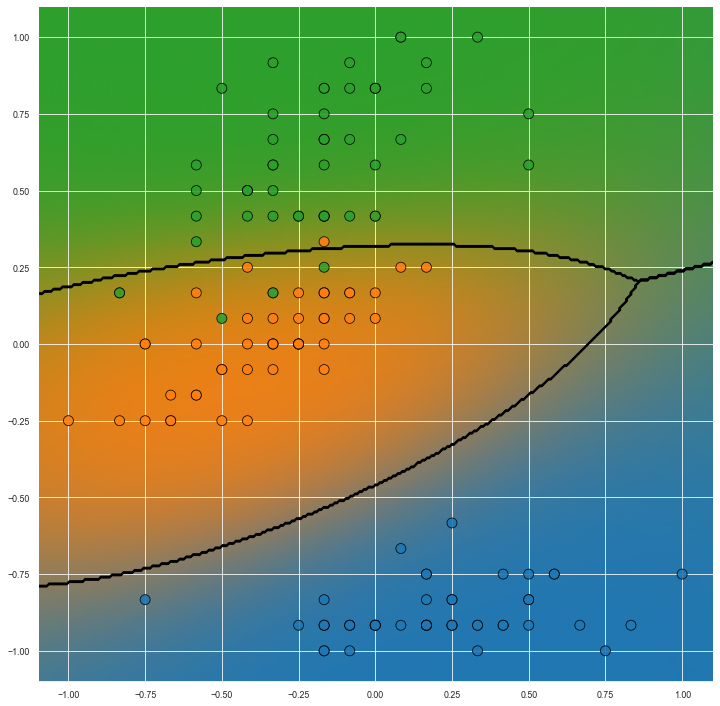

In [22]:
# Learn the classification model
clf = Pipeline([
    ('feat', Nystroem()), 
    ('clf', LogisticRegressionCV(cv=5, multi_class='multinomial', max_iter=1000))
])
clf.fit(X, y)

# Print the decision boundary
prob_conf_plot(X, y, clf)
pl.savefig(f'nystroem.png')